<a href="https://colab.research.google.com/github/mlaricobar/solution-datathon-interbank-2020/blob/desarrollo/DataLogic_copia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install featexp

In [29]:
# Se importan librerias que permitan trabjar con la base
from google.colab import drive, files

import pandas as pd

import matplotlib.pyplot as plt

In [30]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd /gdrive/'My Drive'/Competencias/'[02] Interbank-2020'
!ls -lh '[00] Data'

/gdrive/My Drive/Competencias/[02] Interbank-2020
total 5.1G
-rw------- 1 root root 979M Dec 12 01:33 censo_test.csv
-rw------- 1 root root 748M Dec 12 01:34 censo_train.csv
-rw------- 1 root root  998 Dec 12 01:34 productos.csv
-rw------- 1 root root 1.7G Dec 12 01:34 rcc_test.csv
-rw------- 1 root root 1.4G Dec 12 01:35 rcc_train.csv
-rw------- 1 root root 3.3M Dec 12 01:35 sample_submission.csv
-rw------- 1 root root  30M Dec 12 01:35 se_test.csv
-rw------- 1 root root  28M Dec 12 01:35 se_train.csv
-rw------- 1 root root 122M Dec 12 01:35 sunat_test.csv
-rw------- 1 root root 106M Dec 12 01:35 sunat_train.csv
-rw------- 1 root root 3.0M Dec 12 01:35 y_train.csv


In [4]:
def optimizar_df(df):
  for col_ in df.select_dtypes(include=[int]).columns:
    df[col_] = pd.to_numeric(df[col_], downcast="unsigned")

  for col_ in df.select_dtypes(include=[float]).columns:
    df[col_] = pd.to_numeric(df[col_], downcast="float")
  
  return df

# Análisis Exploratorio de los Datos

In [5]:
# Importamos data de Data_Logic
df_base_train = optimizar_df(pd.read_csv("[00] Data/y_train.csv"))
df_base_test = optimizar_df(pd.read_csv("[00] Data/sample_submission.csv"))

df_rcc_train = optimizar_df(pd.read_csv("[00] Data/rcc_train.csv"))
df_rcc_test = optimizar_df(pd.read_csv("[00] Data/rcc_test.csv"))

df_rcc_train["saldo"] = df_rcc_train["saldo"] + 1
df_rcc_test["saldo"] = df_rcc_test["saldo"] + 1

In [6]:
df_rcc_train.head()

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,PRODUCTO,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR
0,201711,4,0,12,33,0.927399,6,-1,0
1,201711,4,0,12,33,0.929392,7,-1,0
2,201711,4,0,12,61,0.947946,5,-1,0
3,201711,4,0,11,32,0.927544,8,1,0
4,201711,4,0,12,61,0.942123,0,1,0


In [7]:
sorted(df_rcc_train["codmes"].unique())

[201703,
 201704,
 201705,
 201706,
 201707,
 201708,
 201709,
 201710,
 201711,
 201712,
 201801,
 201802]

In [11]:
print(df_rcc_train.loc[df_rcc_train["codmes"] == 201802, "key_value"].nunique(), df_base_train["key_value"].nunique())
print(df_rcc_test.loc[df_rcc_test["codmes"] == 201902, "key_value"].nunique(), df_base_test["key_value"].nunique())

358487 358487
396666 396666


In [12]:
df_rcc_train_last = df_rcc_train.loc[df_rcc_train["codmes"] == 201802].merge(df_base_train, how="left", on="key_value")

In [14]:
df_rcc_train_last.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3251180 entries, 0 to 3251179
Data columns (total 10 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   codmes                    3251180 non-null  uint32 
 1   key_value                 3251180 non-null  uint32 
 2   condicion                 3251180 non-null  uint16 
 3   tipo_credito              3251180 non-null  uint8  
 4   cod_instit_financiera     3251180 non-null  uint8  
 5   saldo                     3251180 non-null  float32
 6   PRODUCTO                  3251180 non-null  uint8  
 7   RIESGO_DIRECTO            3251180 non-null  int64  
 8   COD_CLASIFICACION_DEUDOR  3251180 non-null  uint8  
 9   target                    3251180 non-null  uint8  
dtypes: float32(1), int64(1), uint16(1), uint32(2), uint8(5)
memory usage: 108.5 MB


In [17]:
from featexp import get_univariate_plots

                                         Plots for condicion                                          


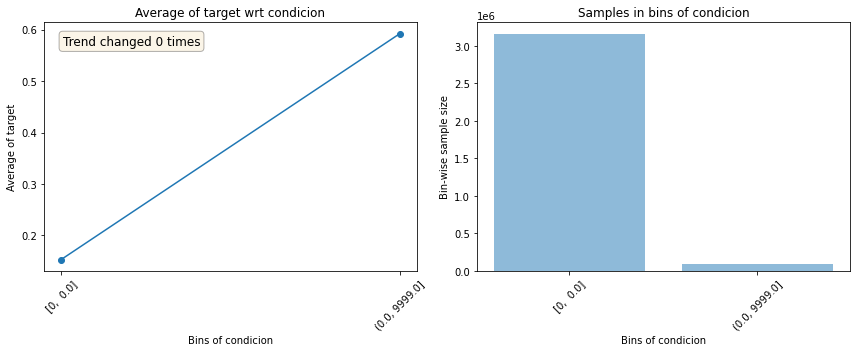

--------------------------------------------------------------------------------------------------------------


                                           Plots for saldo                                            


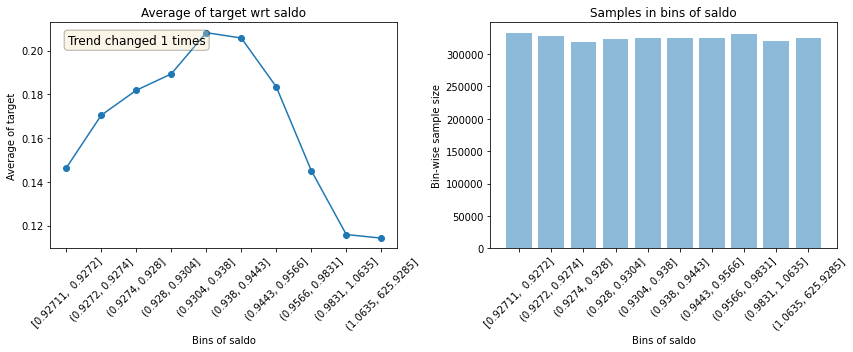

--------------------------------------------------------------------------------------------------------------




In [18]:
get_univariate_plots(data=df_rcc_train_last, target_col='target', features_list=["condicion", "saldo"], bins=10)

# Construcción del Modelo

In [20]:
df_rcc_train_last.head()

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,PRODUCTO,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR,target
0,201802,2991,0,11,34,0.93271,2,-1,0,0
1,201802,2991,0,99,17,0.96070,5,-1,0,0
2,201802,2991,0,11,34,0.93262,3,-1,0,0
3,201802,2991,0,10,17,0.94390,4,1,0,0
4,201802,2991,0,11,34,0.92713,1,-1,0,0


In [45]:
sorted(df_rcc_train_last["RIESGO_DIRECTO"].unique())

[-1, 1, 2, 3, 5]

In [44]:
sorted(df_rcc_train_last["COD_CLASIFICACION_DEUDOR"].unique())

[0, 1, 2, 3, 4, 5]

In [19]:
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score, roc_curve

In [22]:
#  Modelo Arbol de clasificacion
predictores = ['condicion','tipo_credito','cod_instit_financiera','saldo','PRODUCTO','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR']

x = df_rcc_train_last[predictores]
y = df_rcc_train_last['target']

In [23]:
# dividimos la base
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=4)

## Regresión Logística

## Árbol de Decisión

In [34]:
## Importamos el modelo arbol, entrenamos y predecimos la base de test
MTree = DecisionTreeClassifier(criterion='entropy', max_depth = 6, random_state=1)
MTree.fit(x_train,y_train)

y_hat_tree = MTree.predict(x_test)

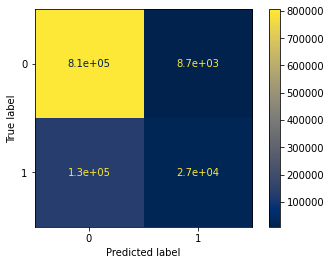

In [35]:
## Matriz de Confusión
plot_confusion_matrix(MTree, x_test, y_test, cmap="cividis")

In [36]:
## Accuracy, Recall, Precision
print("Desicion Tree Accuracy: {0:.2f}".format(accuracy_score(y_test, y_hat_tree)))
print(classification_report(y_test, y_hat_tree))

Desicion Tree Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.86      0.99      0.92    813780
           1       0.75      0.17      0.27    161574

    accuracy                           0.85    975354
   macro avg       0.81      0.58      0.60    975354
weighted avg       0.84      0.85      0.81    975354



<img src="matriz-de-confusion.jpeg" width="400">
<img src="formulas-metricas.png">

In [37]:
precision = 46 / (46 + 8 )
recall = 46 / (46 + 6)
accuracy = (46 + 345) / (46 + 6 + 345 + 8)

print("Precision: {0:.2f}".format(precision))
# De 54 compradores reales mi modelo identificó a 46 (85%)


print("Recall: {0:.2f}".format(recall)) 
# De 52 usuarios que mi modelo catalogó como compradores, 46 de ellos efectivamente compraron el servicio 
# premium (88%)


print("Accuracy: {0:.2f}".format(accuracy)) 
# Del total de usuarios (405) de mi base de test, mi modelo logró identificar correctamente (como compradores y 
# no compradores) a 391 de ellos (97%)

Precision: 0.85
Recall: 0.88
Accuracy: 0.97


### Interpretación del Árbol de Decisión

Profundidad del árbol: 6
Número de nodos terminales: 64


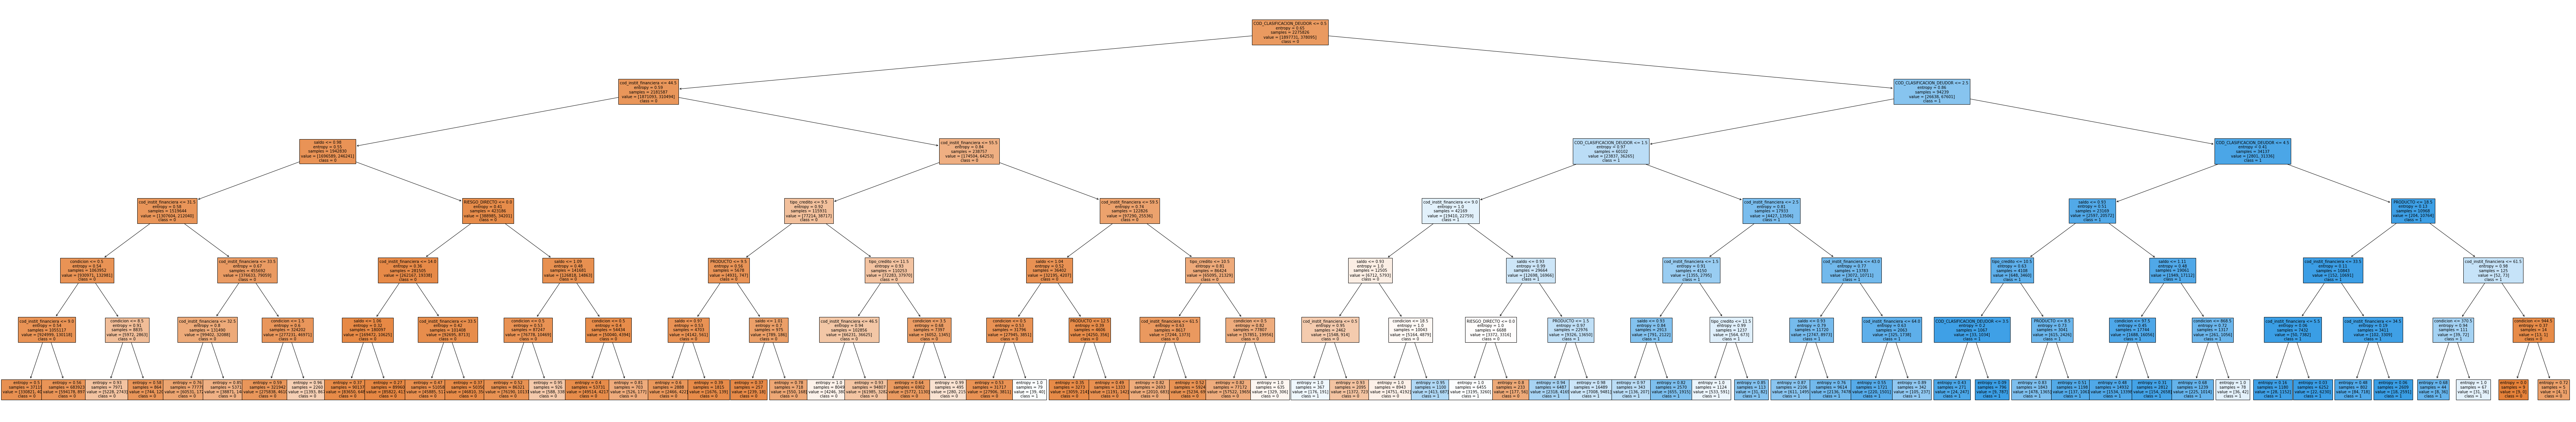

In [46]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(120, 20))

print("Profundidad del árbol: {0}".format(MTree.get_depth()))
print("Número de nodos terminales: {0}".format(MTree.get_n_leaves()))

plot = plot_tree(
            decision_tree = MTree,
            feature_names = predictores,
            class_names   = ["0", "1"],
            filled        = True,
            impurity      = True,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

<img src="entropia-2.png" width="400">



A tener en cuenta:
- Recordemos que la entropía mide el nivel de homogeneidad del conjunto de datos (cuán impuro o no-homogéneo es). Si el conjunto de datos es completamente homogéneo (50% 0s - 50% 1s) la entropía es 1 tal como se muestra en el gráfico.
- **N_samples** es el # de registros en dicho nivel de evaluación. **Values** hace referncia al [# de registros con valor de Target 0 (No Premium), # de regitros con valor de Target 1 (Sí compraron el Premium)]. Class hace referencia a qué etiqueta se le dará si cumple con las condiciones necesarias para llegar a dicho nodo terminal.
- El grado del color depende de la **Entropía**
- **Azul**: Clase preponderante 1. Azul Fuerte: Entropía baja - Azul Claro: Entropía Alta
- **Naranja**: Clase preponderante 0. Naranja Fuerte: Entropía baja - Naranja Claro: Entropía Alta
- En el primer nivel, el nodo raíz usa la variable frecuencia con el valor de 3.5 como primera división permitiendo alcanzar una entropía de 0.56


In [ ]:
# Cálculo de la entropía en el primer nivel 
n_samples = len(y_train)
n_samples_negatives = y_train.value_counts()[0]
n_samples_positives = y_train.value_counts()[1]
entropy_first_level = round(- (n_samples_negatives/n_samples) * (math.log(n_samples_negatives/n_samples, 2))
                      - (n_samples_positives/n_samples) * (math.log(n_samples_positives/n_samples, 2)), 2)

print("# Sample: {0}, Positives: {1}, Negatives: {2}, Entropy: {3}".format(n_samples, n_samples_negatives, n_samples_positives, entropy_first_level))

# Sample: 943, Positives: 821, Negatives: 122, Entropy: 0.56


In [ ]:
# Cálculo de la entropía en el segundo nivel
# Condición 1: Frecuencia <= 3.5 
n_samples = 670
n_samples_negatives = 659
n_samples_positives = 11
entropy_second_level_left = round(- (n_samples_negatives/n_samples) * (math.log(n_samples_negatives/n_samples, 2))
                      - (n_samples_positives/n_samples) * (math.log(n_samples_positives/n_samples, 2)), 2)

print("# Sample: {0}, Positives: {1}, Negatives: {2}, Entropy: {3}".format(n_samples, n_samples_negatives, n_samples_positives, entropy_second_level_left))

# Sample: 670, Positives: 659, Negatives: 11, Entropy: 0.12


In [ ]:
# Condición 2: Frecuencia > 3.5
n_samples = 273
n_samples_negatives = 162
n_samples_positives = 111
entropy_second_level_right = round(- (n_samples_negatives/n_samples) * (math.log(n_samples_negatives/n_samples, 2))
                      - (n_samples_positives/n_samples) * (math.log(n_samples_positives/n_samples, 2)), 2)

print("# Sample: {0}, Positives: {1}, Negatives: {2}, Entropy: {3}".format(n_samples, n_samples_negatives, n_samples_positives, entropy_second_level_right))

# Sample: 273, Positives: 162, Negatives: 111, Entropy: 0.97


In [ ]:
# Ganancia obtenida por la primera regla o condición
round(entropy_first_level - (670 / 943) * (entropy_second_level_left) - (273 / 943) * (entropy_second_level_right), 2)

0.19

Ejemplos:

In [ ]:
from sklearn.tree import export_text
texto_modelo = export_text(
                    decision_tree = MTree,
                    feature_names = predictores
               )
print(texto_modelo)

|--- frecuencia <= 3.50
|   |--- Anti_mes <= 4.50
|   |   |--- class: 1
|   |--- Anti_mes >  4.50
|   |   |--- class: 0
|--- frecuencia >  3.50
|   |--- frecuencia <= 4.50
|   |   |--- Anti_mes <= 5.50
|   |   |   |--- Anti_mes <= 4.50
|   |   |   |   |--- class: 1
|   |   |   |--- Anti_mes >  4.50
|   |   |   |   |--- class: 1
|   |   |--- Anti_mes >  5.50
|   |   |   |--- Anti_mes <= 10.50
|   |   |   |   |--- class: 0
|   |   |   |--- Anti_mes >  10.50
|   |   |   |   |--- class: 0
|   |--- frecuencia >  4.50
|   |   |--- No de asientos mes <= 0.50
|   |   |   |--- class: 1
|   |   |--- No de asientos mes >  0.50
|   |   |   |--- No de asientos mes <= 5.00
|   |   |   |   |--- class: 0
|   |   |   |--- No de asientos mes >  5.00
|   |   |   |   |--- class: 1



In [ ]:
pd.DataFrame({'feature':predictores, 'importance':MTree.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
7,frecuencia,0.516956
8,Anti_mes,0.426580
4,No de asientos mes,0.043519
5,No de asientos mes anterior,0.012945
0,No de facturas mes,0.000000
1,No de compras mes,0.000000
2,No de ingresos mes,0.000000
3,No de egresos mes,0.000000
6,Actvo_Mes,0.000000


### Tuning de Hiper-parametros del Árbol de Decisión

In [ ]:
## Procederemos a iterar los valores del hiper-parámetro para encontrar el modelo con mayor ajuste a los datos de entrenamiento y test
train_accuracy_list, test_accuracy_list = [], []

max_depth_range = list(range(1, 10))
for max_depth in max_depth_range:
    
    MTree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=1)
    MTree.fit(x_train, y_train)
    
    y_train_pred = MTree.predict(x_train)
    y_test_pred = MTree.predict(x_test)
    
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    train_accuracy_list.append(accuracy_train)
    test_accuracy_list.append(accuracy_test)
    
    print("Train - max_depth: {}, accuracy: {}".format(max_depth, accuracy_train))
    print("Test - max_depth: {}, accuracy: {}\n".format(max_depth, accuracy_test))

Train - max_depth: 1, accuracy: 0.870625662778367
Test - max_depth: 1, accuracy: 0.8716049382716049

Train - max_depth: 2, accuracy: 0.9384941675503712
Test - max_depth: 2, accuracy: 0.9407407407407408

Train - max_depth: 3, accuracy: 0.9777306468716861
Test - max_depth: 3, accuracy: 0.9604938271604938

Train - max_depth: 4, accuracy: 0.9809119830328739
Test - max_depth: 4, accuracy: 0.9654320987654321

Train - max_depth: 5, accuracy: 0.9819724284199364
Test - max_depth: 5, accuracy: 0.9629629629629629

Train - max_depth: 6, accuracy: 0.9830328738069989
Test - max_depth: 6, accuracy: 0.9629629629629629

Train - max_depth: 7, accuracy: 0.9830328738069989
Test - max_depth: 7, accuracy: 0.9629629629629629

Train - max_depth: 8, accuracy: 0.9830328738069989
Test - max_depth: 8, accuracy: 0.9679012345679012

Train - max_depth: 9, accuracy: 0.9840933191940615
Test - max_depth: 9, accuracy: 0.9654320987654321



Text(0, 0.5, 'Accuracy')

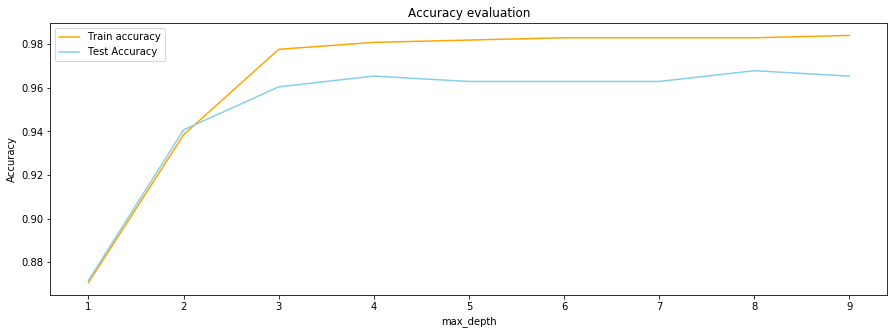

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax.plot(max_depth_range, train_accuracy_list, c='orange')
ax.plot(max_depth_range, test_accuracy_list,  c='skyblue')
ax.set_title('Accuracy evaluation')
ax.legend(['Train accuracy', 'Test Accuracy'])
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')

**Conclusión**:
Luego de revisar qué tanto varía el rendimiento en nuestra base de test, podemos concluir de los gráficos que con **el nivel de profundidad 8** tenemos un mayor rendimientos en la base de test por lo que nos quedaríamos con ese valor del hiperparámetro nivel de profundidad del árbol.


In [ ]:
## Importamos el modelo arbol, entrenamos y predecimos la base de test
MTree = DecisionTreeClassifier(criterion='entropy', max_depth = 8, random_state=1)
MTree.fit(x_train,y_train)

y_hat_tree = MTree.predict(x_test)

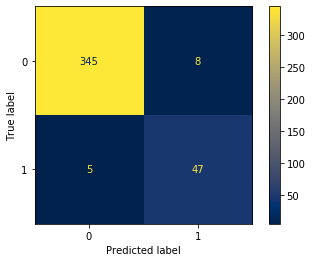

In [ ]:
## Matriz de Confusión
plot_confusion_matrix(MTree, x_test, y_test, cmap="cividis")

---